In [1]:
import numpy as np
import pandas as pd
import re

In [5]:
%pwd

'/Users/boralim/Desktop/capstone'

In [7]:
data = pd.read_csv('/Users/boralim/Desktop/capstone/crawling_naver_iphone.csv', encoding='utf-8')
#column name: description
description = list(data.description)

In [11]:
#구두점 및 특수문자 제거
from string import punctuation
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [12]:
clean_description=[]
for sentance in description:
    result = strip_punctuation(sentance)
    clean_description.append(result)

In [15]:
from konlpy.tag import Kkma
kkma = Kkma() #형태소 분석기

In [2]:
#한글, 영문, 숫자만 남기고 제거
def clean_text(text): 
    text = text.replace(".", " ").strip() 
    text = text.replace("·", " ").strip() 
    text = re.sub('[^ㄱ-ㅣ가-힣|0-9|a-zA-Z]+', repl='', string=text) 
    return text

In [17]:
dataset=[]
for i in range(len(clean_description)):
    dataset.append(kkma.nouns(re.sub('[^가-힣|0-9|a-zA-Z]+', '', clean_description[i])))

In [20]:
from gensim import corpora, models
import gensim

In [21]:
#데이터를 dictionary 형태로 명사 리스트 만들기
dataset2=dataset
dataset2=[[y for y in x if not len(y)==1] for x in dataset2]
dictionary=corpora.Dictionary(dataset2)
corpus=[dictionary.doc2bow(text) for text in dataset2]

In [22]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel

#CoherenceModel을 통한 토픽 최적화: 토픽이 얼마나 의미론적으로 일관성 있는지 판단. 높을수록 의미론적 일관성 높음
coherence_values=[]
for i in range(2,15):
    ldamodel=gensim.models.ldamodel.LdaModel(corpus,num_topics=i,id2word=dictionary)
    coherence_model_lda=CoherenceModel(model=ldamodel, texts=dataset2, dictionary=dictionary, topn=10)
    coherence_lda=coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

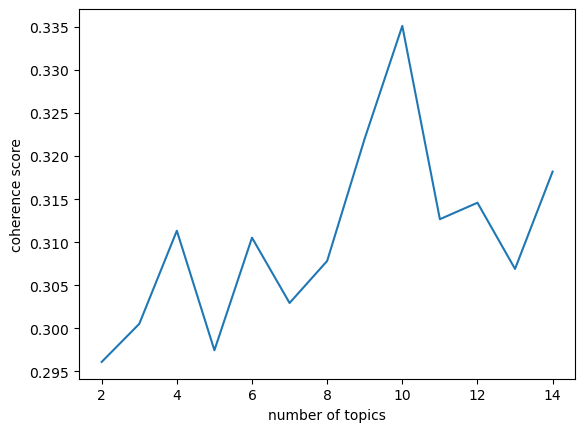

In [23]:
x=range(2, 15)
plt.plot(x, coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

In [24]:
ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=10, alpha=0.1, id2word=dictionary)

In [25]:
ldamodel.print_topics(num_words=20)

[(0,
  '0.026*"12" + 0.025*"아이" + 0.025*"아이폰12" + 0.014*"케이스" + 0.013*"프로" + 0.006*"사용" + 0.006*"미니" + 0.006*"안녕" + 0.005*"맥스" + 0.005*"주문" + 0.005*"제작" + 0.005*"아이폰" + 0.005*"하세" + 0.005*"가죽" + 0.004*"주문제작전문가" + 0.004*"전문가" + 0.004*"레더" + 0.004*"케이스아이" + 0.004*"카드" + 0.004*"필름"'),
 (1,
  '0.042*"아이" + 0.041*"12" + 0.040*"아이폰12" + 0.016*"프로" + 0.015*"미니" + 0.014*"아이폰" + 0.009*"이번" + 0.009*"케이스" + 0.009*"사용" + 0.006*"구입" + 0.006*"모델" + 0.006*"핸드폰" + 0.005*"필름" + 0.005*"디자인" + 0.005*"유리" + 0.005*"강화" + 0.005*"스마트" + 0.004*"시리즈" + 0.004*"강화유리" + 0.004*"액정"'),
 (2,
  '0.043*"아이" + 0.043*"아이폰12" + 0.042*"12" + 0.015*"케이스" + 0.015*"미니" + 0.014*"아이폰" + 0.012*"프로" + 0.007*"사용" + 0.007*"구매" + 0.006*"모델" + 0.005*"카메라" + 0.005*"맥스" + 0.005*"사진" + 0.005*"시리즈" + 0.004*"투명" + 0.004*"가격" + 0.004*"애플" + 0.004*"이번" + 0.003*"디자인" + 0.003*"추천"'),
 (3,
  '0.030*"아이" + 0.029*"12" + 0.029*"아이폰12" + 0.012*"미니" + 0.008*"아이폰" + 0.006*"사용" + 0.006*"구입" + 0.006*"케이스" + 0.005*"11" + 0.003*"크기" + 0.003*"제품" + 0.00

In [36]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
vis

/Users/boralim/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.057212  0.007914       1        1  24.279845
1      0.046799 -0.011972       2        1  13.838675
9      0.052588 -0.091554       3        1  12.953492
6      0.031700  0.061235       4        1  12.294548
2      0.040596  0.031068       5        1  11.875586
5      0.042137  0.023888       6        1   9.998157
0     -0.070319  0.042349       7        1   4.537068
8     -0.059684 -0.000942       8        1   4.520072
3     -0.032685 -0.040723       9        1   4.441117
4     -0.108343 -0.021264      10        1   1.261439, topic_info=       Term        Freq       Total Category  logprob  loglift
0        12  764.000000  764.000000  Default  30.0000  30.0000
6        아이  768.000000  768.000000  Default  29.0000  29.0000
8     아이폰12  754.000000  754.000000  Default  28.0000  28.0000
47       미니  204.000000  204.000000  Default  27.0000  27.0000
80       사용  134.000000  134.000000  Default  26.0000  26.0000
...     ...         ...         ...      ...      ...      ...
1532     출고    0.342238    8.565071  Topic10  -6.5632   1.1530
208      원래    0.342219   15.663642  Topic10  -6.5632   0.5493
1852  카메라부분    0.342201    5.144595  Topic10  -6.5633   1.6626
2802     고요    0.342197    3.339962  Topic10  -6.5633   2.0946
897      부분    0.342196   22.768683  Topic10  -6.5633   0.1752

[760 rows x 6 columns], token_table=      Topic      Freq Term
term                      
15        1  0.317398   11
15        2  0.101567   11
15        3  0.266614   11
15        4  0.076176   11
15        5  0.025392   11
...     ...       ...  ...
1397      2  0.364713   힐링
1397      3  0.091178   힐링
1397      4  0.182357   힐링
1397      5  0.182357   힐링
1397      6  0.182357   힐링

[1428 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 10, 7, 3, 6, 1, 9, 4, 5])